# Imports 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import copy

In [2]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
stop_words = set(stopwords.words('english'))
import re
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jaccard
%matplotlib inline

In [3]:
from ekphrasis.classes.exmanager import ExManager
from ekphrasis.classes.spellcorrect import SpellCorrector

In [4]:
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [5]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

In [6]:
EMBEDDING_DIM = 300 # how big is each word vector
VOCAB_SIZE = 20000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 100 # max number of words in a comment to use
seed = 42
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
path =  r'C:\Users\Ruslan_Golubev\Documents\laba task3 toxic comments\laba-task3-toxic-comments'
regexes = ExManager().get_compiled()

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


# Auxillary functions

In [7]:
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
 
 
    def on_train_begin(self, logs={}):
        return
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, epoch, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred, average='macro', sample_weight=None)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return
 
    def on_batch_begin(self, batch, logs={}):
        return
 
    def on_batch_end(self, batch, logs={}):
        return

In [12]:
def handle_elongated_match(m):
        text = m.group()
        regexes = ExManager().get_compiled()
        text = regexes["normalize_elong"].sub(r'\1', text)

        return text


# разметка и нижний регистр
def cleaning(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df
# числа
def no_num(token_sents):
    
    list_of_sents = []
    sents = []
    for sent in token_sents:
        sents = []
        for token in sent:
            if token.isalpha():
                sents.append(token)
        list_of_sents.append(sents)
    return list_of_sents

def lemma(df):
    lem = WordNetLemmatizer()
    lemma_tokens = []
    for i in df['tokens'].values:
        tokens = [lem.lemmatize(word, "v") for word in i]
        lemma_tokens.append(tokens)
    return lemma_tokens

def full_preproc(df, text_field):
    temp_df = cleaning(df, text_field)
    temp_df[text_field] = temp_df[text_field].apply(lambda x: regexes["elongated"].sub(lambda w: handle_elongated_match(w), x))
    tokenizer = RegexpTokenizer(r'\w+')
    temp_df['tokens'] = temp_df[text_field].apply(tokenizer.tokenize)
    temp_df['tokens'] = temp_df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
    temp_df['tokens'] = no_num(temp_df['tokens'].values)
    temp_df['lemma_tokens'] = lemma(temp_df)
    return temp_df

In [65]:
def model(x_t, y_t, x_v, y_v, embd_w):
    inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = Embedding(VOCAB_SIZE, 
                  EMBEDDING_DIM,
                  weights=[embd_w])(inp)
    x = Bidirectional(LSTM(50, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam')
    
    model.fit(x_t,
          y_t,
          validation_data=(x_v, y_v),
          callbacks=[roc_callback(training_data=(x_t, y_t), validation_data=(x_v, y_v))], 
                     batch_size=64, 
                     epochs=2, 
                     verbose=1
         )
    return model

def pred_and_sub(inp_model):
    y_test = inp_model.predict(padded_test_data, batch_size=1024, verbose=1)
    submission_df = pd.DataFrame(columns=['id'] + label_names)
    submission_df['id'] = data_test['id'].values 
    submission_df[label_names] = y_test 
    submission_df.to_csv("./submission.csv", index=False)
    return 

# Data loading

In [9]:
data_train = pd.read_csv(r'C:\Users\Ruslan_Golubev\Documents\laba task3 toxic comments\train.csv')
data_test = pd.read_csv(r'C:\Users\Ruslan_Golubev\Documents\laba task3 toxic comments\test.csv')
#test_labels = pd.read_csv(r'C:\Users\Ruslan_Golubev\Documents\laba task3 toxic comments\test_labels.csv')
#sample_submission = pd.read_csv(r'C:\Users\Ruslan_Golubev\Documents\laba task3 toxic comments\sample_submission.csv')

In [10]:
y = data_train[label_names]

# EDA

In [10]:
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Псмотрим сколько всего нетоксичных и всяких токсичных комментов 

In [11]:
x = data_train.iloc[:,2:].sum()
rowsums=data_train.iloc[:,2:].sum(axis=1)
print("Total comments ",data_train.shape[0])
print("Nomber of non-toxic comments",list(pd.DataFrame(rowsums==0).sum())[0])
print("Total toxic ",x.sum())

Total comments  159571
Nomber of non-toxic comments 143346
Total toxic  35098


Получается у нас топик может быть разнообразно токсичен (то есть и угроза и обзывательство и тд). Посмотрим как распределены комменты по различным токсичностям.

In [12]:
col_names = data_train.columns.values[2:]
col_names = col_names.tolist()
col_names.append('None')
x = [sum(data_train[y]) for y in data_train.columns.values[2:]]
x.append(len(data_train) - sum(x))

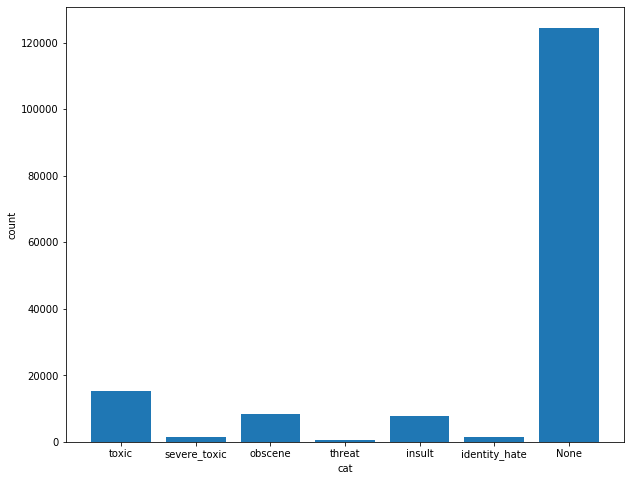

In [13]:
plt.figure(figsize = (10, 8))
plt.bar(np.arange(len(x)),x)
plt.xticks(np.arange(len(x)), col_names)
plt.xlabel('cat')
plt.ylabel('count')
plt.show()

Классы сильно несбалансиврованы. Еще можно посмотреть на количество текстов с миксом токсик тэгов

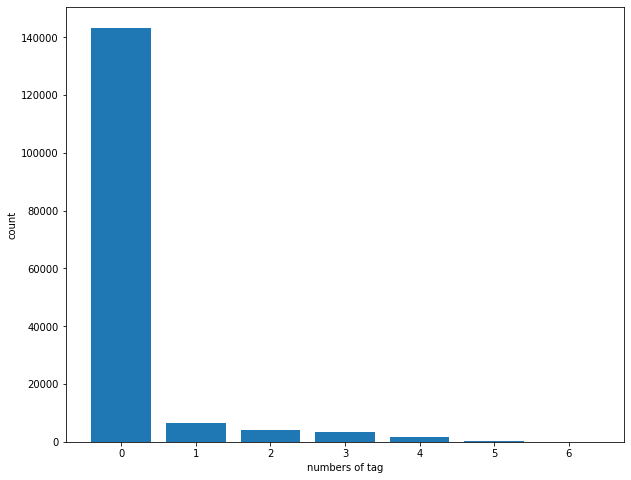

In [14]:
x=rowsums.value_counts()
plt.figure(figsize = (10, 8))
plt.bar(np.arange(len(x)),x)
plt.xticks(np.arange(len(x)))
plt.xlabel('numbers of tag')
plt.ylabel('count')
plt.show()

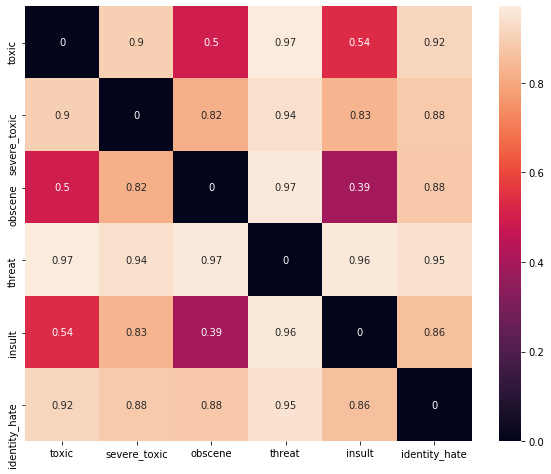

In [31]:
corr = pd.DataFrame(columns = temp_df.columns, index = temp_df.columns)
for i in range(len(corr.columns)):
    corr[corr.columns[i]] = [jaccard(temp_df[corr.columns[i]].values, temp_df[corr.columns[j]].values) for j in range(len(corr.columns))]
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)    

In [250]:
text_lens = []
for text in tqdm(data_train['lemma_tokens']):
        text_lens.append(len(text))


100%|█████████████████████████████████████████████████████████████████████████| 159571/159571 [00:00<00:00, 2070615.79it/s]


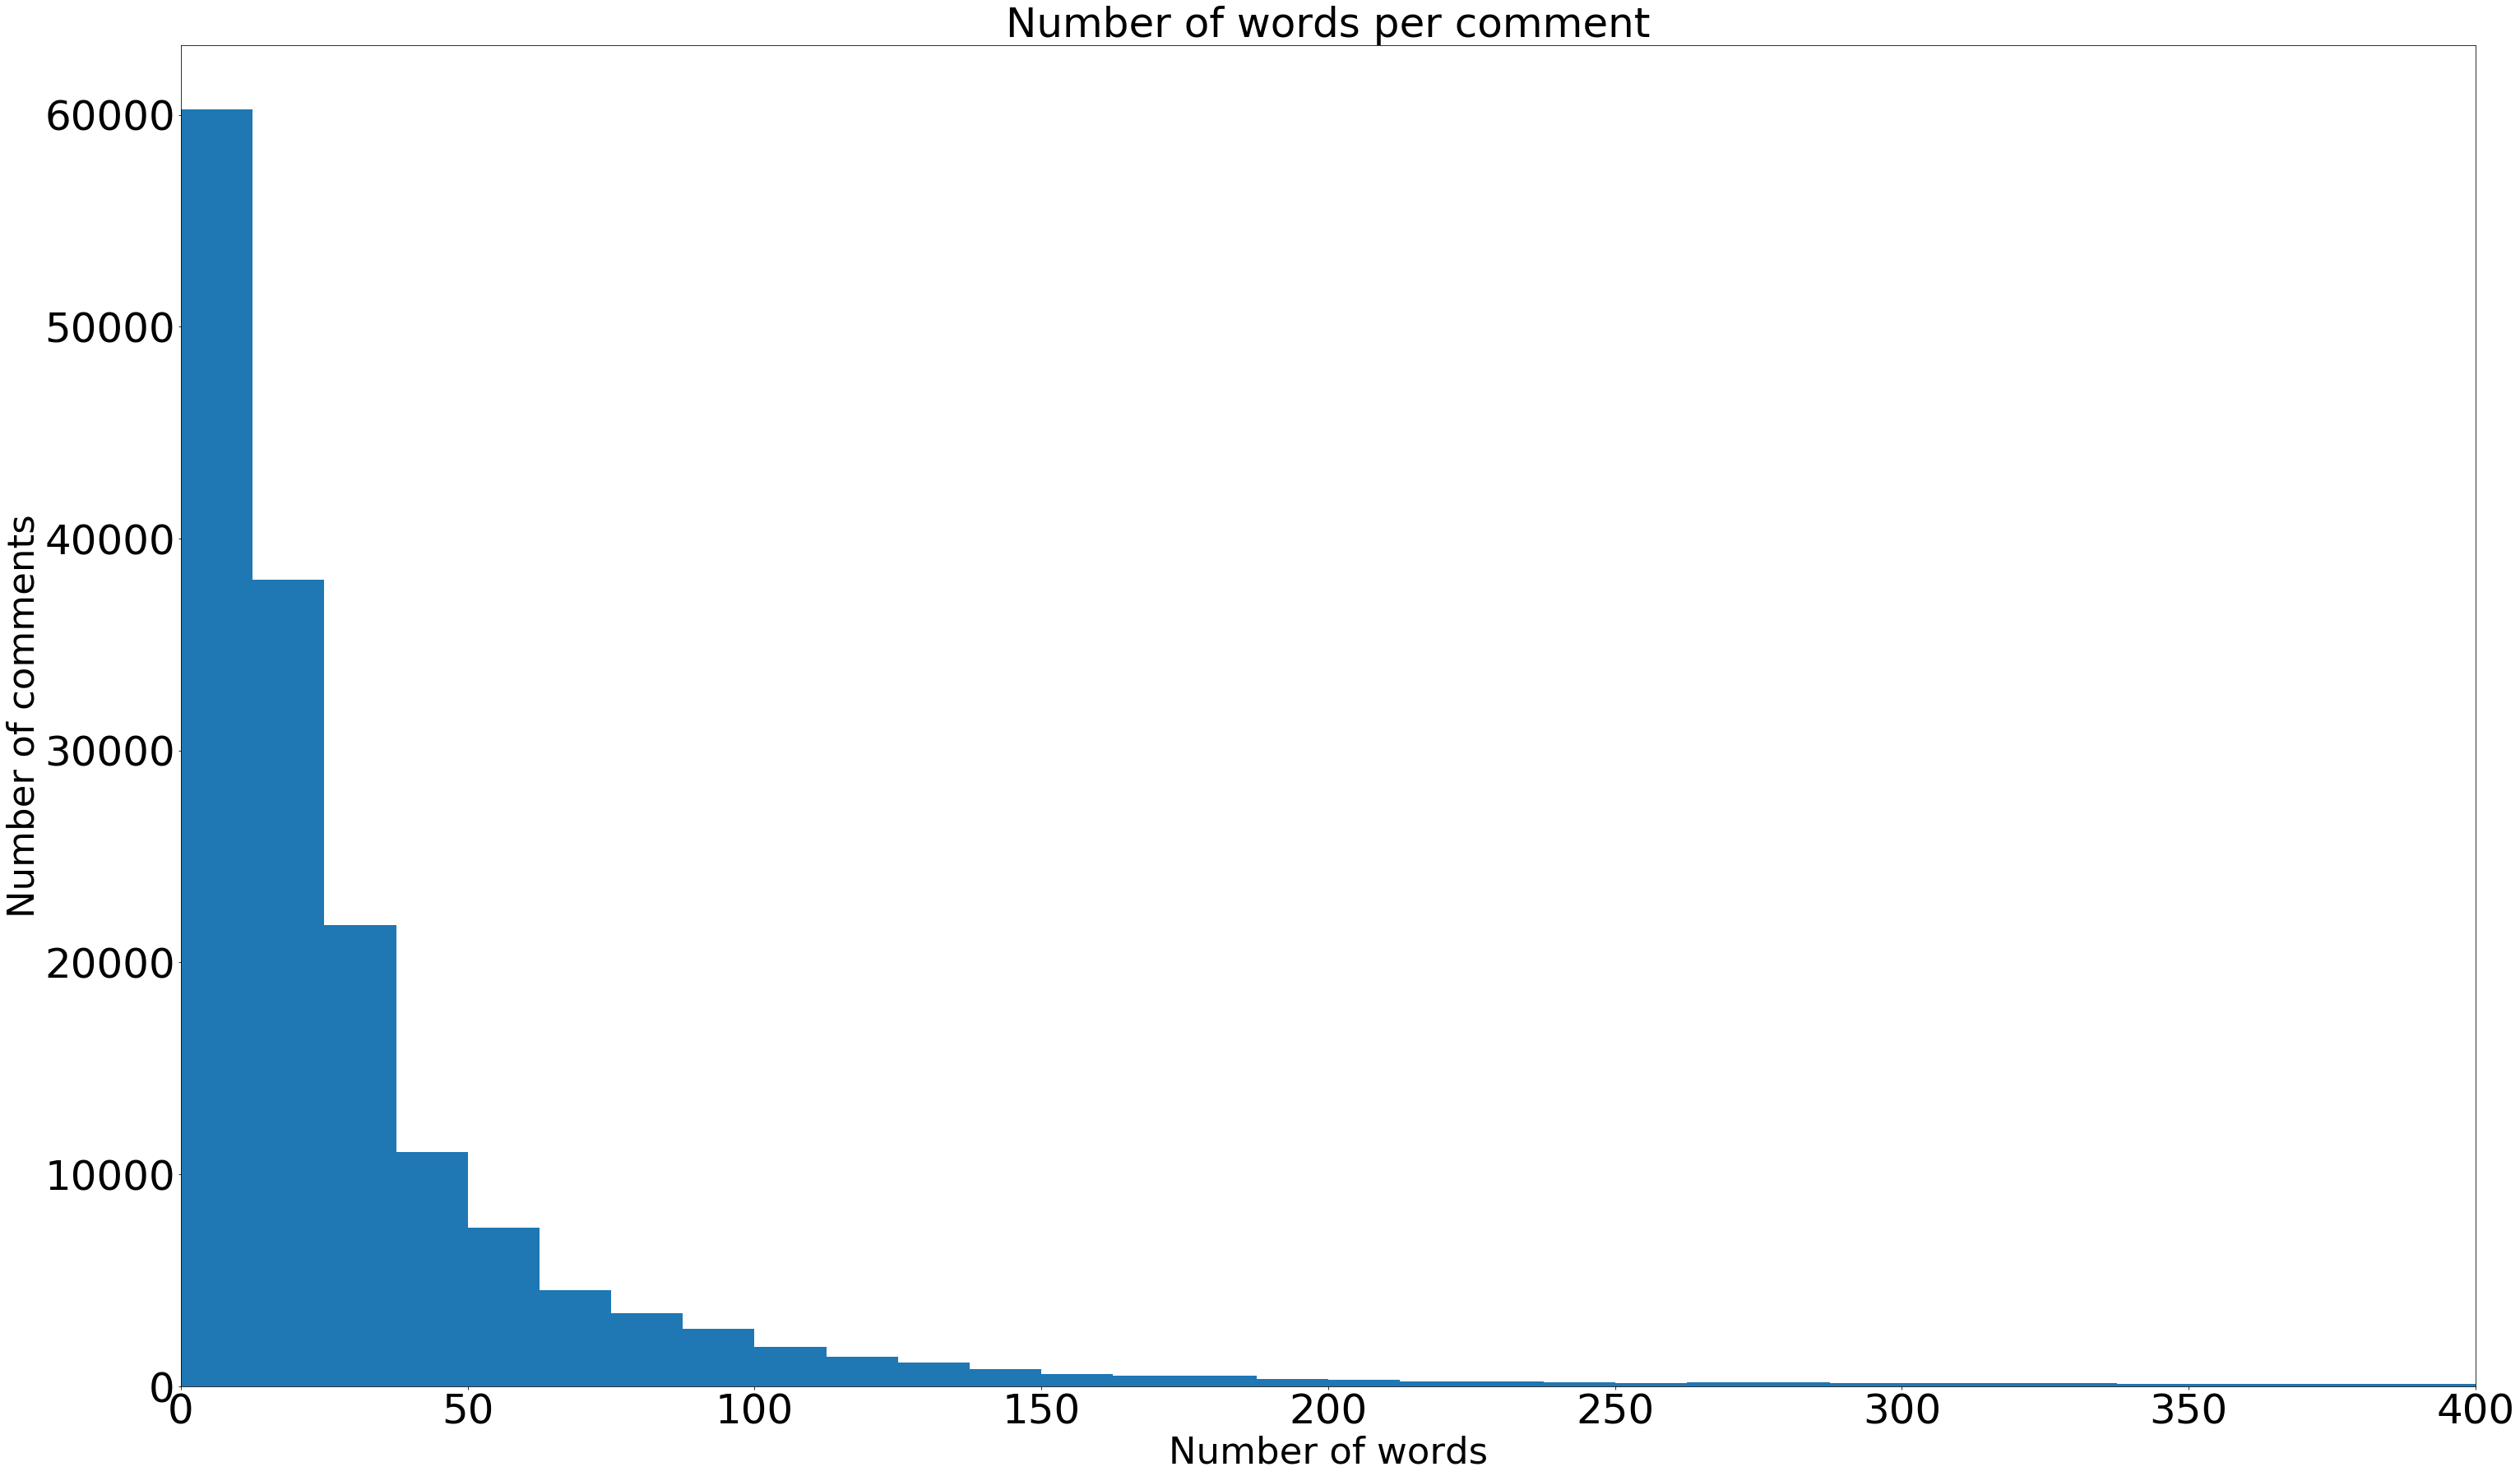

In [265]:
f = plt.figure(figsize=(50, 30))
plt.axes()
f.gca().set_xlim((0, 400))
plt.hist(text_lens, bins= 100)
plt.tick_params(axis='both', which='major', labelsize=50)

plt.title('Number of words per comment', fontsize=50)
plt.xlabel('Number of words', fontsize=45)
plt.ylabel('Number of comments', fontsize=45)
plt.show()

In [257]:
np.median(text_lens)

18.0

In [258]:
np.mean(text_lens)

34.0266025781627

# Preprocessing

In [23]:
#data_train = full_preproc(data_train, 'comment_text')
#data_test = full_preproc(data_test, 'comment_text')
#with open('./data_train.p', 'wb') as f:
 #   pickle.dump(data_train, f)
#with open('./data_test.p', 'wb') as f:
 #   pickle.dump(data_test, f)
data_train = pickle.load(open('./data_train_toxic.p', "rb" ))
data_test = pickle.load(open('./data_test_toxic.p', "rb"))

In [24]:
words = [word for tokens in data_train['tokens'] for word in tokens]
vocab = set(words)
vocab_size = len(vocab)
print('Vocabulary size', vocab_size)

Vocabulary size 159834


In [25]:
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tokens,lemma_tokens,lemma_tokens_sents
0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0,"[explanation, edits, made, username, hardcore,...","[explanation, edit, make, username, hardcore, ...",explanation edit make username hardcore metall...
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,"[aww, matches, background, colour, seemingly, ...","[aww, match, background, colour, seemingly, st...",aww match background colour seemingly stick th...
2,000113f07ec002fd,"hey man, i'm really not trying to edit war it...",0,0,0,0,0,0,"[hey, man, really, trying, edit, war, guy, con...","[hey, man, really, try, edit, war, guy, consta...",hey man really try edit war guy constantly rem...
3,0001b41b1c6bb37e,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0,"[make, real, suggestions, improvement, wondere...","[make, real, suggestions, improvement, wonder,...",make real suggestions improvement wonder secti...
4,0001d958c54c6e35,"you, sir, are my hero any chance you remember...",0,0,0,0,0,0,"[sir, hero, chance, remember, page]","[sir, hero, chance, remember, page]",sir hero chance remember page


### Загружаем предобученный W2V

In [26]:
w2v_path = path + '\GoogleNews-vectors-negative300.bin.gz'
w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_path, binary=True)

С помощью keras tokenizer создаем индексированный словарь и предложения в виде последовательности индексов.

In [27]:
data_train['lemma_tokens_sents'] = data_train['lemma_tokens'].apply(lambda x: ' '.join(x))
data_test['lemma_tokens_sents'] = data_test['lemma_tokens'].apply(lambda x: ' '.join(x))

In [30]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=False, char_level=False)

tokenizer.fit_on_texts(data_train['lemma_tokens_sents'].tolist())

training_sequences = tokenizer.texts_to_sequences(data_train['lemma_tokens_sents'].tolist())
test_sequences = tokenizer.texts_to_sequences(data_test['lemma_tokens_sents'].tolist())

Обрезаем слишком длинные комментарии и добавляем паддинги в короткие.

In [31]:
padded_train_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [32]:
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 148128 unique tokens.


In [33]:
train_embedding_weights = np.zeros((len(list(train_word_index.items())[:20000]), EMBEDDING_DIM))
for word,index in list(train_word_index.items())[:19999]:
    train_embedding_weights[index,:] = w2v[word] if word in w2v else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(20000, 300)


# W2V

In [34]:
X_train, X_val, y_train, y_val = train_test_split(padded_train_data, y, test_size=0.2, random_state=seed)

In [ ]:
model = model(X_train, y_train, X_val, y_val, train_embedding_weights)

In [39]:
pred_and_sub(model)
# 0.97782
# 0.97789 после удаления слов с большим повторением букв


153164/153164 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 35 - ETA: 35 - 

# Glove

In [42]:
import os

In [44]:
import io
embeddings_index = {}
with io.open(path+'\glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [47]:
train_glove_embedding_weights = np.zeros((len(list(train_word_index.items())[:20000]), EMBEDDING_DIM))
temp = 0
for word,index in list(train_word_index.items())[:19999]:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        train_glove_embedding_weights[index] = embedding_vector
print(train_glove_embedding_weights.shape)

(20000, 300)


In [ ]:
model_glove = model(X_train, y_train, X_val, y_val, train_glove_embedding_weights)

In [55]:
pred_and_sub(model_glove)
# 0.97149
# 0.97807 после удаления слов с большим повторением букв 

153164/153164 [==============================] - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - E

# Flair

In [56]:
from flair.data import Sentence

In [57]:
from flair.embeddings import WordEmbeddings

ft_embedding = WordEmbeddings('en')

In [62]:
train_ft_embedding_weights = np.zeros((len(list(train_word_index.items())[:20000]), EMBEDDING_DIM))
for word,index in list(train_word_index.items())[:19999]:
    embedding_vector = ft_embedding.get_cached_vec(word)
        # words not found in embedding index will be all-zeros.
    train_ft_embedding_weights[index] = np.array(embedding_vector)
print(train_ft_embedding_weights.shape)

(20000, 300)


In [ ]:
model_ft = model(X_train, y_train, X_val, y_val, train_ft_embedding_weights)

In [67]:
pred_and_sub(model_ft)
# 0.97702

153164/153164 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - 